# Imports

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
import pathlib

PROJECT_ROOT = pathlib.Path().cwd().parent
sys.path.append(str(PROJECT_ROOT))

image_path = PROJECT_ROOT / 'ReMIND2Reg_dataset' / 'imagesTr'

from src.utils import *
from src.datatype import MRIDataset, iUSDataset
from src.renderer import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nibabel as nib
import torch
import torch.nn.functional as F
from sklearn.cluster import KMeans

c:\Users\noe\anaconda3\envs\torchIO\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
patient_id = "005" # between 000 and 102, t1 and t2 don't exist for all patients
iUS_file = f"ReMIND2Reg_0{patient_id}_0000.nii.gz"
t1_file = f"ReMIND2Reg_0{patient_id}_0001.nii.gz"
t2_file = f"ReMIND2Reg_0{patient_id}_0002.nii.gz"
# dataset = MRIDataset([image_path / t1_file], "T1", axis=0)

In [5]:
dataset = MRIDataset([image_path / t1_file, image_path / t2_file], "T1", axis=0)
T1 = dataset[0]
T1_volume = T1["image"].squeeze(0)       # (D,H,W)
T2 = dataset[1]
T2_volume = T2["image"].squeeze(0)       # (D,H,W)

US = iUSDataset(image_path / iUS_file, "iUS", axis=0)

In [6]:
import numpy as np
from scipy.ndimage import binary_dilation, binary_erosion

def create_brain_mask(volume, threshold=50):
    """
    Quick brain mask generation by thresholding and cleaning.
    volume: np.ndarray, MRI volume
    threshold: int, intensity below which is considered air/background
    """
    mask = volume > threshold
    mask = binary_dilation(mask, iterations=2) # pourquoi?
    mask = binary_erosion(mask, iterations=2) # pourquoi? 
    return torch.from_numpy(mask)

def zscore_normalize(volume, mask):
    """
    Normalize a volume by z-scoring inside a brain mask.
    Args:
        volume: torch.Tensor, the 3D volume to normalize.
        mask: torch.Tensor, binary brain mask of the same shape as the volume.
    
    Returns:
        torch.Tensor: The z-score normalized volume.
    """
    volume = volume.float()
    brain_voxels = volume[mask > 0]
    mean = brain_voxels.mean()
    std = brain_voxels.std()
    
    volume_norm = (volume - mean) / (std + 1e-8)  
    return volume_norm

import torch.nn as nn

class ImpedanceEstimator(nn.Module):
    """MLP for estimating acoustic impedance from normalized intensity values."""
    def __init__(self, input_dim: int = 1):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 32), nn.ReLU(),
            nn.Linear(32, 32), nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

    @classmethod
    def train_model(cls,
                    X: torch.Tensor,
                    y: torch.Tensor,
                    input_dim: int = 1,
                    lr: float = 1e-3,
                    epochs: int = 5000) -> 'ImpedanceEstimator':
        """Train impedance estimation model on paired data."""
        model = cls(input_dim)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        loss_fn = nn.MSELoss()
        
        for _ in range(epochs):
            optimizer.zero_grad()
            loss = loss_fn(model(X), y)
            loss.backward()
            optimizer.step()
            
        return model

    @staticmethod
    def compute_impedance_volume(
        volume: torch.Tensor,
        model: 'ImpedanceEstimator',
        threshold: float = 50
    ) -> torch.Tensor:
        """Generate full impedance volume using trained model and preprocessing."""
        mask = create_brain_mask(volume, threshold)
        vol_norm = zscore_normalize(volume.float(), mask)
        
        with torch.no_grad():
            Z_pred = model(vol_norm[mask].unsqueeze(1)).squeeze() * 1e6
            
        Z_vol = torch.full_like(volume, 400.0)  # Default air impedance
        Z_vol[mask] = Z_pred
        return Z_vol

In [7]:
T1_data = pd.DataFrame(
    {"organ": ["fat","liver","muscle","BWM","BGM","CSF","AIR"],
     "intensity": [260,500,870,780,920,2500, 0], 
     "impedance": [1.34e6,1.67e6,1.68e6,1.6e6,1.6e6,1.5e6, 0.0004e6]}
)

In [15]:
T1_volume = T1_volume.float()
T2_volume = T2_volume.float()

# t1 = np.array([-2.0, -1.0, 0.0,  1.5]).reshape(-1,1)
t1 = T1_data['intensity'].values.reshape(-1,1)
t2 = np.array([-2.0, -0.5, 0.0,  2.0]).reshape(-1,1)
# z1 = np.array([400,  1.52e6, 1.7e6, 1.38e6]).reshape(-1,1)/1e6
z1 = T1_data['impedance'].values.reshape(-1,1)
z2 = np.array([400,  1.38e6, 1.7e6, 1.52e6]).reshape(-1,1)/1e6

X1 = torch.tensor(t1, dtype=torch.float32)
Y1 = torch.tensor(z1, dtype=torch.float32)
X2 = torch.tensor(t2, dtype=torch.float32)
Y2 = torch.tensor(z2, dtype=torch.float32)

model_t1 = ImpedanceEstimator.train_model(X1, Y1, input_dim=1)
model_t2 = ImpedanceEstimator.train_model(X2, Y2, input_dim=1)

Z_vol = ImpedanceEstimator.compute_impedance_volume(T1_volume, model_t1, threshold=50)
Z_vol2 = ImpedanceEstimator.compute_impedance_volume(T2_volume, model_t2, threshold=50)

# Alignement

In [16]:
# render source
base_Z = Z_vol.clone() + Z_vol2.clone()

In [21]:
UR = UltrasoundRenderer(200, 0.0001)

angle = 30  # degrees
rays = 200

thetas = np.radians(np.linspace(-angle,angle, rays))  # 64 rays across the fan
directions = [np.array([np.sin(theta), np.cos(theta), 0]) for theta in thetas]

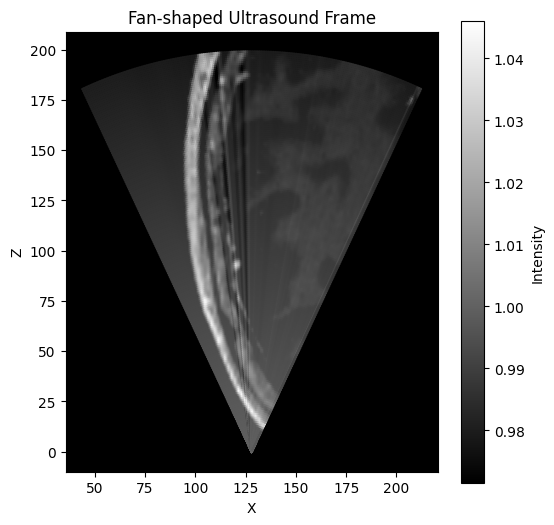

In [22]:
obj = UR.plot_beam_frame(
    volume=base_Z,
    source = torch.tensor([100,0, 40.]),
    directions = torch.tensor(directions),
    angle=25,
)

MRI Plot so less processing


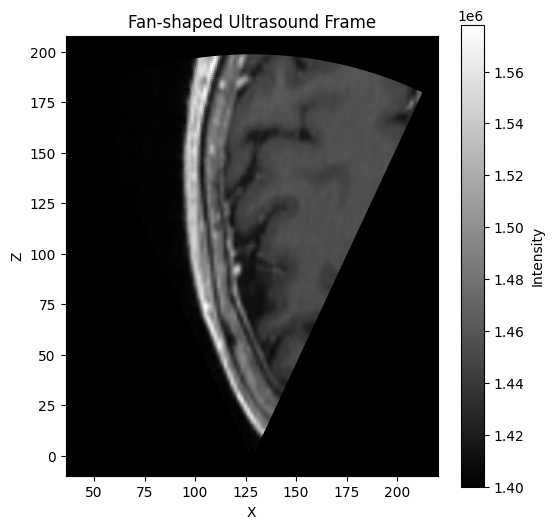

In [24]:
obj = UR.plot_beam_frame(
    volume=T1_volume,
    source = torch.tensor([100,0, 40.]),
    directions = torch.tensor(directions),
    angle=25,
    MRI=True
)

In [11]:
source = torch.tensor([150.,0,90.], requires_grad=True)
directions_t = torch.tensor(directions, dtype=torch.float32, requires_grad=True)

obj2 = UR.plot_beam_frame(
    volume=base_Z,
    source = source,
    directions = directions_t,
    angle=25,
    plot=False,
)

F.mse_loss(obj2, obj)

tensor(0.0001, grad_fn=<MseLossBackward0>)

In [12]:
def directions_t(theta):
    thetas = thetas = np.radians(np.linspace(-angle,angle, rays))  # 64 rays across the fan
    return torch.tensor(
    [np.array([np.sin(theta), np.cos(theta), 0]) 
     for theta in thetas], requires_grad=True)

optimizer = torch.optim.Adam([source, directions_t], lr=1)

for step in range(100):
    optimizer.zero_grad()
    frame = UR.plot_beam_frame(
        volume=base_Z, 
        source=source, 
        directions=directions_t, 
        plot=False)
    loss = F.mse_loss(frame, obj)
    loss.backward()
    optimizer.step()
    print(f"Step {step}, Loss: {loss.item():.8f}")


TypeError: optimizer can only optimize Tensors, but one of the params is __main__.directions_t

In [ ]:
directions

[array([-0.34202014,  0.93969262,  0.        ]),
 array([-0.33872142,  0.94088671,  0.        ]),
 array([-0.33541852,  0.94206922,  0.        ]),
 array([-0.3321115 ,  0.94324014,  0.        ]),
 array([-0.32880038,  0.94439944,  0.        ]),
 array([-0.32548523,  0.94554713,  0.        ]),
 array([-0.32216606,  0.94668317,  0.        ]),
 array([-0.31884293,  0.94780757,  0.        ]),
 array([-0.31551588,  0.9489203 ,  0.        ]),
 array([-0.31218494,  0.95002135,  0.        ]),
 array([-0.30885016,  0.95111071,  0.        ]),
 array([-0.30551158,  0.95218836,  0.        ]),
 array([-0.30216925,  0.95325429,  0.        ]),
 array([-0.29882319,  0.95430849,  0.        ]),
 array([-0.29547345,  0.95535095,  0.        ]),
 array([-0.29212008,  0.95638165,  0.        ]),
 array([-0.28876311,  0.95740058,  0.        ]),
 array([-0.28540259,  0.95840772,  0.        ]),
 array([-0.28203855,  0.95940307,  0.        ]),
 array([-0.27867104,  0.96038661,  0.        ]),
 array([-0.27530011,